In [6]:
#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.fftpack import rfft, irfft, fftfreq
import pickle
import os
from random import randrange

def threshhold(data, thld):
    length = len(data)
    tdata = np.zeros((length))
    for i_index, i in enumerate(data):
        if i < thld:
            tdata[i_index] = 0
        else:
            tdata[i_index] = i
    return tdata

def filterDC(data, freq = 10):
    f_data = rfft(data)
    for j in range(10):
        f_data[j] = 0
    return irfft(f_data)

def visualiseCorr(corr):
    fig, ax = plt.subplots(figsize=(40,15))
    image = corr
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax.set_title('dropped spines')
    
    # Move left and bottom spines outward by 10 points
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()




def filter_interest(corr, sweep, thld):
    newsweep = []
    smoothed_sweep = []
    newcorr = []
    #print(corr, len(corr))
    #print(sweep, len(sweep))
    #print(max(sweep))
    for index, val in enumerate(threshhold(corr, thld)):
        if val:
            newcorr.append(val)
            interest_point = sweep[index]
            smoothed_sweep.append(interest_point)
            #print([range(interest_point-50, interest_point+50)])
            newsweep += [i for i in range(interest_point-1, interest_point+1)]
    #plt.scatter(sweep, corr, s=1, marker='.')
    #plt.show()
    return np.array(sorted(list(set(newsweep))))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

def drawfft(x, y, dt):
    import matplotlib.pyplot as plt
    import numpy as np
    f_x = rfft(x)
    f_y = rfft(y)

    dt = 0.01
    Fs = 1/dt
    
    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.magnitude_spectrum(x, Fs=Fs)

    plt.subplot(1, 2, 2)
    plt.magnitude_spectrum(y, Fs=Fs)

    plt.show()
    
def drawDistribution(x, y):
    #print(min(x), max(x), min(y), max(y))
    minData = min([min(x), -max(x), min(y), -max(y)])
    maxData = -minData
    #print(minData, maxData)
    bins = np.arange(minData, maxData, 0.0001)
    xDig = np.digitize(x, bins)
    yDig = np.digitize(y, bins)
    Z = np.zeros((len(bins), len(bins)))
    #print(len(Z))
    #print(len(Z[0]))
    X = bins
    Y = bins
    #print(len(X))
    for i,j in zip(xDig, yDig):
        Z[i][j] += 1
    zmax = np.amax(Z)
    #print(np.amin(Z))
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d') 
    ax.plot_surface(X, Y, Z, 
                    #rstride=3, 
                    #cstride=3, 
                    alpha=0.3,            # transparency of the surface 
                    cmap=cm.BuPu)
    cset = ax.contourf(X, Y, Z, 
                       zdir='z',          # direction to project the contour
                       offset=zmax,        # how "far" render the contour map 
                       alpha=0.3,
                       cmap=cm.winter)    # winter colour map
    cset = ax.contourf(X, Y, Z, 
                       zdir='x', 
                       offset=minData, 
                       cmap=cm.cool)
    cset = ax.contourf(X, Y, Z, 
                       zdir='y', 
                       offset=maxData, 
                       cmap=cm.coolwarm)
    ax.set_xlabel('X')
    ax.set_xlim(minData, maxData)
    ax.set_ylabel('Y')
    ax.set_ylim(minData, maxData)
    ax.set_zlabel('Z')
    ax.set_zlim(0, zmax)
    ax.set_title('3D surface and contours', va='bottom')

    ax.view_init(elev=50, azim=-50)           # elevation and angle
    ax.dist=12
    plt.show()
    plt.pcolormesh(X, Y, Z, cmap='brg', vmin=0, vmax=zmax)
    plt.title('pcolormesh')
    # set the limits of the plot to the limits of the data
    plt.axis([minData, maxData, minData, maxData])
    plt.colorbar()
    plt.show()
    pass

def analyse(txFile, rxFile, size=0, threshold = 90, dt= 0.01):    
    from ipyparallel import Client
    import numpy as np
    c = Client(profile='default')
    dview = c[:]
    
    @dview.parallel(block=True)
    def correlateblock(data):
        import numpy as np
        res = []
        for d in data:
            a = d['a']
            b = d['b']
            block = d['block']
            sweep = d['sweep']
            #if not block % 5:
            windowsize = d['windowsize']
            #print('block',block)
            #print('sweep', sweep)
            #print('windowsize', windowsize)
            corr = np.zeros(len(sweep))
            y = a[block*windowsize:(1+block)*windowsize]
            #print('a[',block*windowsize,':',(1+block)*windowsize,']')

            for index, value in enumerate(sweep):#range(len(a)-windowsize):
                x = b[0+value:windowsize+value]
                #print('\tb[',0+value,':',windowsize+value,']', end=' ')
                corr[index] = np.corrcoef(x, y)[0,1]
                #print(corr[index])
            res.append({'block':block, 'sweep': sweep, 'corr':corr})
        return res
    
    def correlate(a, b, windowsize, block, sweep):
        corr = np.zeros(len(sweep))
        jobs = []
        for j in block:
            ublock = j
            usweep = (sweep + (ublock * windowsize)) % (len(a)-windowsize)
            #print(usweep, len(usweep))
            sweepB = [usweep[i:i + 10000] for i in range(0, len(usweep), 10000)]
            jobs += [{'a':a, 'b':b, 'block':ublock, 'windowsize':windowsize, 
                     'sweep':i} for i in sweepB]
        #print("jobs:", jobs)
        #print("total jobs:", len(jobs))
        data = correlateblock(jobs)
        for i in data:
            newsweep = (np.array(i['sweep']) - (i['block'] * windowsize)) % (len(a)-windowsize)
            for ind, val in enumerate(newsweep):                
                #corr[np.where(sweep==val)[0]] += i['corr'][ind] 
                corr[np.searchsorted(sweep,val)] += i['corr'][ind]

        return np.array(corr)/len(block)
    print(len(dview))
    master = np.genfromtxt(
        txFile,
        #'C13-7.300000.csv',           # file name
        #'t3p8-6p9-17-12.csv',
        skip_header=5,          # lines to skip at the top
        skip_footer=0,          # lines to skip at the bottom
        delimiter=',',          # column delimiter
        dtype='float64',        # data type
        filling_values=0,       # fill missing values with 0
        usecols = (0,1),    # columns to read
        names=['Time', ',Ampl'])     # column names
    slave = np.genfromtxt(
        rxFile,
        #'C23-7.300000.csv',           # file name
        #'r3p8-6p9-17-12.csv',
        skip_header=5,          # lines to skip at the top
        skip_footer=0,          # lines to skip at the bottom
        delimiter=',',          # column delimiter
        dtype='float32',        # data type
        filling_values=0,       # fill missing values with 0
        usecols = (0,1),    # columns to read
        names=['Time', 'Ampl'])     # column names
    MData = master['Ampl']
    SData = slave['Ampl']
    if size == 0:
        size = len(MData)
    elif size < 10000:
        size = 10000
    print (size)
    a = MData[0:size] #[0:100000]
    b = SData[0:size]
    
    x = filterDC(b) #[0:100000]
    y = filterDC(a)

    windowsize0 = 2*100
    block = np.array(range(0, 4), dtype=np.int)
    sweep = np.array(range(len(x)-windowsize0), dtype=np.int)
    correlation = []
    corr = []
    i = 0
    for i in range(4):
        #print(len(sweep))
        windowsize = windowsize0*(2**i)
        #print('windowsize :', windowsize)
        #print(windowsize, block, sweep)
        corr = correlate(x, y, windowsize, block, sweep)
        thld = max(corr)*threshold/100
        #print(thld)
        sweep = filter_interest(corr, sweep, thld)
        correlation.append({'sweep': sweep, 'corr': corr})
        #print(corr)
        #print(sweep)
    syncPoint = sweep[np.argmax(corr)]
    print("Signal synced at :", syncPoint)
    plt.figure(figsize=(10,3))
    plt.plot(x[:200])
    plt.plot(y[syncPoint:200+syncPoint])
    plt.ylabel('Synced Signal Time Train')
    plt.show()
    x_n, y_n = x[0:-syncPoint], y[syncPoint:]
    drawfft(x_n, y_n, dt)    
    drawDistribution(x_n, y_n)
    return x_n, y_n, correlation, syncPoint

4
20000
Signal synced at : 2907


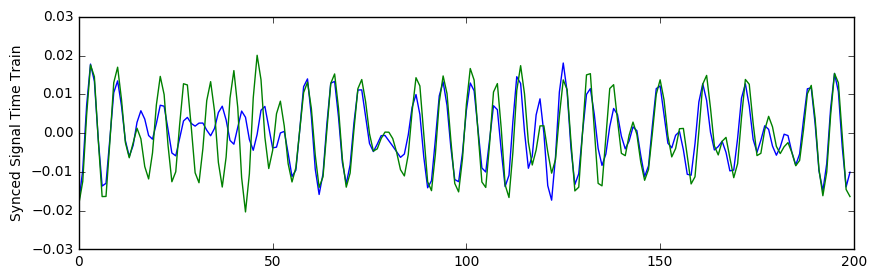

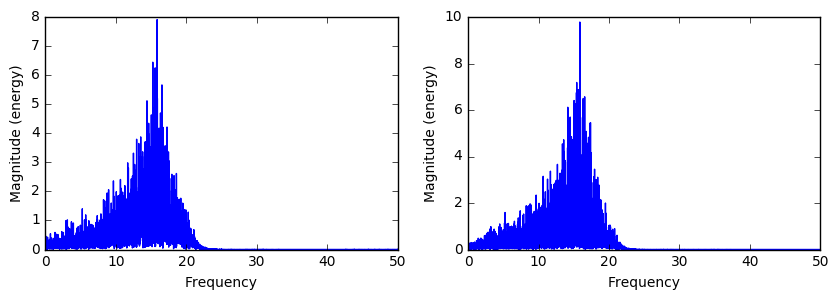

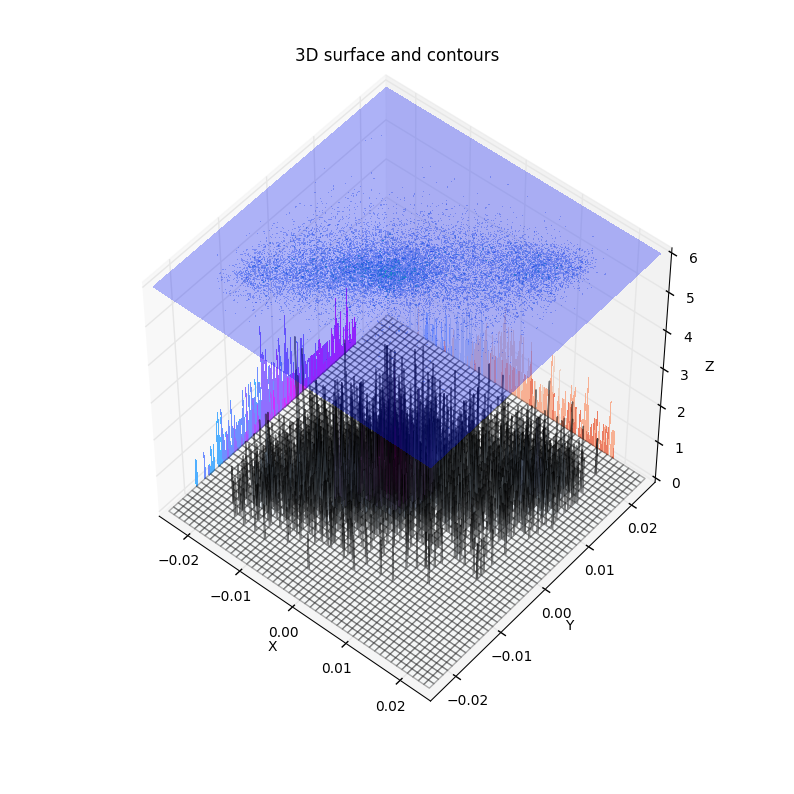

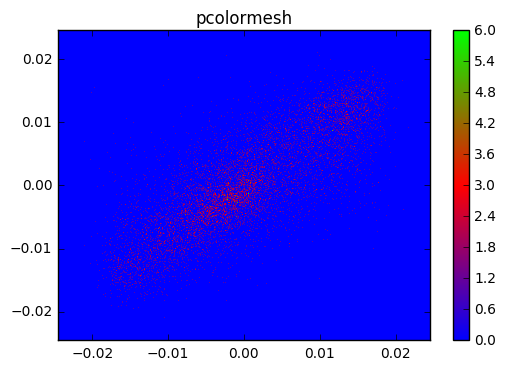

In [7]:
#%matplotlib inline
size=20000
threshold=80
dt = 0.01
x, y, correlation, syncPoint = analyse('t3p8-6p9-17-12.csv', 'r3p8-6p9-17-12.csv', size=size, threshold=threshold, dt=dt)